# Contents

[**0. Setup**](##setup)

[**1. Cleaning the data**](##cleaning-the-data)

**2. Exploring the data**
   
**3. Conclusions**

# 0. Setup

Import the libraries and set up plotting settings.

In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

/Users/mihai/.pyenv/versions/3.7.5/envs/flight_data_3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/mihai/.pyenv/versions/3.7.5/envs/flight_data_3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Import the data.

In [266]:
airlines = pd.read_csv('./data/airlines.csv')
airports = pd.read_csv('./data/airports.csv')
flights = pd.read_csv('./data/flights.csv')
weather = pd.read_csv('./data/weather.csv')

# 1 Cleaning the data

In [215]:
def describe_dataframe(df):
    print('Table dimensions:', df.shape)
    
    df.iloc[0:0]
    df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'data_type'})
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'#_null_values'}))
    df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'%_null_values'}))
    
    print('\n')
    print(df.head())
    print('\n')
    print(df_info.head())

In [102]:
describe_dataframe(airlines)

Table dimensions: (16, 2)


  carrier                    name
0      9E       Endeavor Air Inc.
1      AA  American Airlines Inc.
2      AS    Alaska Airlines Inc.
3      B6         JetBlue Airways
4      DL    Delta Air Lines Inc.


              carrier    name
data_type      object  object
#_null_values       0       0
%_null_values       0       0


In [152]:
describe_dataframe(airports)

Table dimensions: (1458, 8)


   FAA                           name   latitude  longitude  altitude  UTC  \
0  04G              Lansdowne Airport  41.130472 -80.619583      1044   -5   
1  06A  Moton Field Municipal Airport  32.460572 -85.680028       264   -6   
2  06C            Schaumburg Regional  41.989341 -88.101243       801   -6   
3  06N                Randall Airport  41.431912 -74.391561       523   -5   
4  09J          Jekyll Island Airport  31.074472 -81.427778        11   -5   

               DST          timezone  
0  US standard DST  America/New_York  
1  US standard DST   America/Chicago  
2  US standard DST   America/Chicago  
3  US standard DST  America/New_York  
4  US standard DST  America/New_York  


                  FAA    name latitude longitude altitude    UTC     DST  \
data_type      object  object  float64   float64    int64  int64  object   
#_null_values       0       0        0         0        0      0       0   
%_null_values       0       0        

In [173]:
describe_dataframe(flights)
print('\n')
print('The airport codes', (set(flights['origin']) | set(flights['destination'])) - set(airports['FAA']), 'do not exist in the airports table.')

Table dimensions: (328063, 12)


   year  month  day  departure  scheduled_departure  arrival  \
0  2013      1    1        517                  515      830   
1  2013      1    1        533                  529      850   
2  2013      1    1        542                  540      923   
3  2013      1    1        544                  545     1004   
4  2013      1    1        554                  600      812   

   scheduled_arrival carrier  flight_id origin destination  distance  
0                819      UA       1545    EWR         IAH      1400  
1                830      UA       1714    LGA         IAH      1416  
2                850      AA       1141    JFK         MIA      1089  
3               1022      B6        725    JFK         BQN      1576  
4                837      DL        461    LGA         ATL       762  


                year  month    day departure scheduled_departure arrival  \
data_type      int64  int64  int64     int64               int64   int64   
#_

In [200]:
print("Weather data is from:", set(weather['origin']))
print('\n')
describe_dataframe(weather)

print('\n')
print('Under 500m visibility happened for', sum(weather['visibility']<0.5), 'hours.')
print('Under 100m visibility happened for', sum(weather['visibility']<0.1), 'hours.')

Weather data is from: {'JFK', 'LGA', 'EWR'}


Table dimensions: (26115, 14)


  origin  year  month  day  hour  temperature  dewpoint  humidity  \
0    EWR  2013      1    1     1        39.02     26.06     59.37   
1    EWR  2013      1    1     2        39.02     26.96     61.63   
2    EWR  2013      1    1     3        39.02     28.04     64.43   
3    EWR  2013      1    1     4        39.92     28.04     62.21   
4    EWR  2013      1    1     5        39.02     28.04     64.43   

   wind_direction  wind_speed  wind_gust  precipitation  pressure  visibility  
0           270.0    10.35702        NaN            0.0    1012.0        10.0  
1           250.0     8.05546        NaN            0.0    1012.3        10.0  
2           240.0    11.50780        NaN            0.0    1012.5        10.0  
3           250.0    12.65858        NaN            0.0    1012.2        10.0  
4           260.0    12.65858        NaN            0.0    1011.9        10.0  


               origin   y

## First look at databases

1. Airlines:
    - could replace the carrier in the flights table with the name of the airline for clearer representation.


2. Airports: 
    - will add lat_origin, long_origin, alt_origin, lat_destination, long_destination, alt_destination to flights table as they will become relevant for plotting on the map and the checking whether altitude plays a role in correlation with weather (e.g. a flight might be delayed because the destination is in the mountains (instable weather) and landing is impossible.) 
    - UTC, timezone are irrelevant as the timezone difference information is contained in the arrival and departure times.
    - name is relevant later for plotting


3. Flights: 
    - Type of departure/arrival is float64, while type of scheduled_departure/scheduled_arrival is int64. Will convert the former to int64.
    - Will add column hour to be able to join with the Weather table.
    - The codes {'SJU', 'ERW', 'PSE', 'BQN', 'STT'} do not correspond to any airports in the airports table. All except for 'ERW' are real airports, 'ERW' is probably just a typo of 'EWR' and I will change it accordingly. 
    - Add lat_origin, long_origin, alt_origin, lat_destination, long_destination, alt_destination columns with information from Airports.
    - 8255 flights have no departure times and 8713 have no arrival times (around 2.5% each) and will drop this data from the table as it will cause problems when computing delays.
    - No flights ever departed earlier than 4:48 AM.
    
    
4. Weather:
    - temperature/dewpoint/humidity
        * very important on cold days/mornings as the plane will freeze and needs to be unfrozen before it can depart. One should check if morning/winter flights have larger delays than summer flights.
        * will fill in one NULL value for temperature, dewpoint, humidity with the value an hour before.       
    - wind
        * wind_speed correlated to wind_direction and the direction of the landing strip should have an impact on departing airplanes
        * wind_gusts could be very important, but the data is 80% missing, maybe because there were no wind gusts.
        * One should check whether in the 20% of the cases where we have wind_gusts data there is a correlation with bigger delays.
        * will fill all the NULL values for wind with 0
    - visibilitity
        * From the USA aviation standards: Reported in a four figure group (e.g. 0400 = 400 metres; 8000 = 8 km) up to but excluding 10 km; 9999 = 10km or more; 0000 = less than 50 metres visibility.)
        * There are 195 instances in the weather database with under 0.5km visibility, but planes can still take off if there is more than 100m of visibility. Under 100m of visibility happened only 16 instances.
        * One should check if on the 379 instances, there are significant delays.
    - precipitation
        * relevant if temperature is freezing (hence probably snow) and landing strip needs to be cleared before take off/landing or if rain is intense
    - pressure 
        * is more or less irrelevant as its variations are very small
    - hours
        * need to multiply with 100 to be able to compare with data in flights
   
 **Goal**: Will join all the usefull data into the working data frame and will use only that for predictions and visualizations.
 

In [267]:
flights.dropna(inplace=True)
flights.departure = flights.departure.astype(int)
flights.arrival = flights.arrival.astype(int)
flights = flights.replace('ERW','EWR')
flights['hour'] = flights['departure'].apply(lambda x : int((x/100))*100)

In [268]:
weather.loc[:,'hour'] *= 100
weather = weather.fillna(0.0)

In [269]:
data = pd.merge(pd.merge(flights, airports, how='left', left_on='origin', right_on='FAA'), airports, how='left', left_on = 'destination', right_on='FAA')
data = data.dropna()

In [366]:
df = data[data['month'] == 1]
wf = weather[weather['month'] == 1]

In [417]:
def to_minutes(number):
    if number == 2400: minutes = 1440
    minutes = int(number/100)*60+int(number%100)
    if number < 448: minutes += 1440
    #I chose 448 because no flight left earlier than 4:48AM
    return minutes

In [421]:
working = pd.merge(df, wf, how = 'left', on=['origin', 'year', 'month', 'day', 'hour']).dropna()

working['date'] = pd.to_datetime(working[['year','month','day']])

working['departure_delay'] =   working['departure'].apply(to_minutes) - working['scheduled_departure'].apply(to_minutes)
working['arrival_delay'] =  working['arrival'].apply(to_minutes) - working['scheduled_arrival'].apply(to_minutes) 

variables_to_remove = ['year','month','day', 'DST_x', 'timezone_x', 'DST_y', 'timezone_y', 'FAA_x', 'FAA_y']
working.drop(variables_to_remove, axis = 1, inplace = True)


# 2 Exploring the data

In [532]:
print(working[working['departure_delay']<0]['departure_delay'].count(), 'flights left early.')
print(working[working['departure_delay']>=0]['departure_delay'].count(), 'flights left late.')

14988 left early.
10760 left late.


I am confused as to whether the following 3 flights left way early or left late the next day. I will just drop them as outliers.


In [464]:
print(working[working['departure_delay'] < -30][['departure','scheduled_departure', 'flight_id', 'departure_delay']])

      departure  scheduled_departure  flight_id  departure_delay
143         848                 1835       3944             -587
6821        641                  900         51             -139
7952       1121                 1635       3695             -314


In [474]:
indexNames = working[working['departure_delay'] < -30].index
working.drop(indexNames , inplace=True)

In [475]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [537]:
print('Total flights by airport\n')
print(working['origin'].groupby(working['origin']).count().sort_values())

print('\nStats for departure delay by airport\n')
print(working[working['departure_delay']>0]['departure_delay'].groupby(working['origin']).apply(get_stats).unstack().sort_values('count'))

print('\nStats for arrival delay by airport\n')
print(working[working['arrival_delay']>0]['arrival_delay'].groupby(working['origin']).apply(get_stats).unstack().sort_values('count'))

print('\nPercentages of delayed flights by airport\n')
print((working[working['departure_delay']>0]['departure_delay'].groupby(working['origin']).count()/working['origin'].groupby(working['origin']).count()).sort_values())

print('\nStats for distances by airport\n')
print(working[working['departure_delay']>0]['distance'].groupby(working['origin']).apply(get_stats).unstack().sort_values('count'))

Total flights by airport

origin
JFK     5983
LGA     7752
EWR    12013
Name: origin, dtype: int64

Stats for departure delay by airport

        min    max   count       mean
origin                               
JFK     1.0  360.0  2043.0  32.737641
LGA     1.0  478.0  2187.0  33.129401
EWR     1.0  599.0  5171.0  37.154709

Stats for arrival delay by airport

        min    max   count       mean
origin                               
JFK     1.0  370.0  2220.0  32.939189
LGA     1.0  486.0  3140.0  29.049682
EWR     1.0  612.0  5636.0  39.252484

Percentages of delayed flights by airport

origin
LGA    0.282121
JFK    0.341467
EWR    0.430450
dtype: float64

Stats for distances by airport

         min     max   count         mean
origin                                   
JFK     94.0  4983.0  2043.0  1165.275086
LGA     96.0  1620.0  2187.0   849.702789
EWR     80.0  4983.0  5171.0  1004.669310


In [540]:
print('\nStats for departure delay by carrier\n')
print(working[working['departure_delay']>0]['departure_delay'].groupby(working['carrier']).apply(get_stats).unstack().sort_values('count'))

print('\nStats for arrival delay by carrier\n')
print(working[working['arrival_delay']>0]['arrival_delay'].groupby(working['carrier']).apply(get_stats).unstack().sort_values('count'))

print('\nPercentages of delayed flights by carrier\n')
print((working[working['departure_delay']>0]['departure_delay'].groupby(working['carrier']).count()/working['origin'].groupby(working['carrier']).count()).sort_values())


Stats for departure delay by carrier

          min    max   count       mean
carrier                                
OO       67.0   67.0     1.0  67.000000
HA        1.0  123.0    10.0  45.100000
F9        2.0  248.0    14.0  55.571429
YV        1.0  238.0    15.0  50.333333
AS        1.0  222.0    23.0  31.869565
FL        1.0  210.0    75.0  27.866667
VX        1.0  246.0    88.0  14.875000
US        1.0  336.0   349.0  26.220630
WN        1.0  259.0   389.0  27.904884
MQ        1.0  360.0   560.0  38.714286
9E        1.0  360.0   573.0  52.015707
DL        1.0  599.0   784.0  32.979592
AA        1.0  337.0   845.0  30.164497
B6        1.0  502.0  1618.0  31.259580
UA        1.0  385.0  2011.0  23.081551
EV        1.0  379.0  2046.0  51.539589

Stats for arrival delay by carrier

           min    max   count        mean
carrier                                  
OO       107.0  107.0     1.0  107.000000
HA         6.0   82.0     6.0   40.000000
YV         1.0  228.0    20.0   39.8

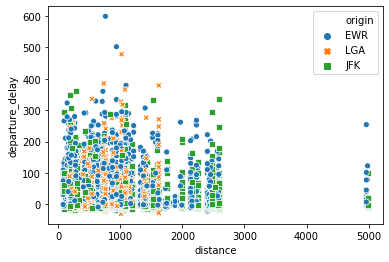

In [545]:
sns.scatterplot(x="distance", y="departure_delay", hue="origin", style="origin", legend="full", data=working)

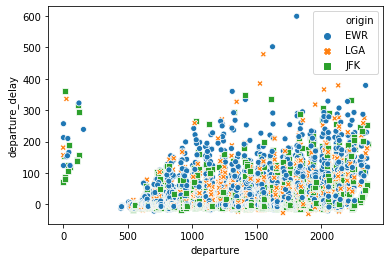

In [546]:
sns.scatterplot('departure', 'departure_delay', hue="origin", style="origin", data=working)

{'min': -69, 'max': 365, 'count': 25748, 'mean': -3.372611464968153}


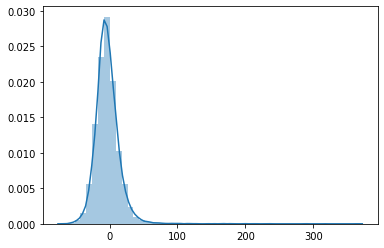

In [496]:
differences = working['arrival_delay'] - working['departure_delay']
print(get_stats(differences))
sns.distplot(differences)

The differences between arrival delays and departure delays are normally distributed around -3.37 and that is probably due to the fact that planes tend to recover some time in the air. 

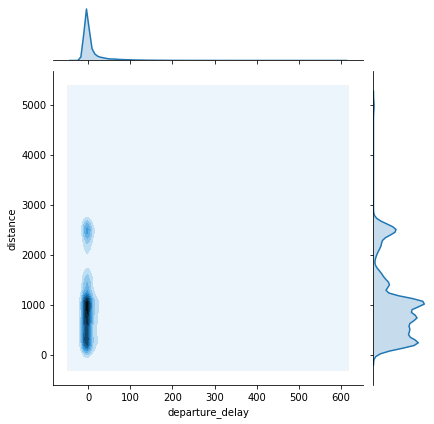

In [510]:
sns.jointplot(working['departure_delay'], working['distance'], kind = 'kde', )